# Exploring the use of Animal Faces dataset

## Importing basic packages
- numpy: computiong library for large/multidimensioanl array and functions
- pandas: data analysis and data manipulation

In [1]:
import numpy as np
import pandas as pd

For AI modeling there are two main libraries:
- Tensoflow - Google brain
- Pytorch - Meta AI

In [2]:
import tensorflow as tf 
import torch as pt

2024-03-23 18:21:07.977632: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 18:21:07.977769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 18:21:08.075995: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Checking tensorflow & torch versions

In [3]:
print("Tensorflow version: " + tf.__version__)
print("PyTorch version: " + pt.__version__)

Tensorflow version: 2.15.0
PyTorch version: 2.1.2


# Importing a dataset from Kaggle

In [4]:
import os
from PIL import Image

In [5]:
src_dirs = ['/kaggle/input/animal-faces/afhq/train/cat', '/kaggle/input/animal-faces/afhq/train/dog', '/kaggle/input/animal-faces/afhq/val/cat', '/kaggle/input/animal-faces/afhq/val/dog']
dst_dir = '/kaggle/working/'

In [6]:
os.makedirs(dst_dir, exist_ok=True)

In [7]:
import os
dir_path = '/kaggle/working/' #define directory
items = os.listdir(dir_path) #list all items in the directory
for item in items: #print all folders
    if os.path.isdir(os.path.join(dir_path, item)):
        print(item)

In [8]:
import os
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In every train dataset cat & dog we have around 821 pictures that are called flickr_cat or flickr_dog and around 4834 pixabay_cat or pixabay_dog. Overall in the dataset I have around 5655 images for cat & around 5655 images for dog.

Every image has 512×512 resolution. 

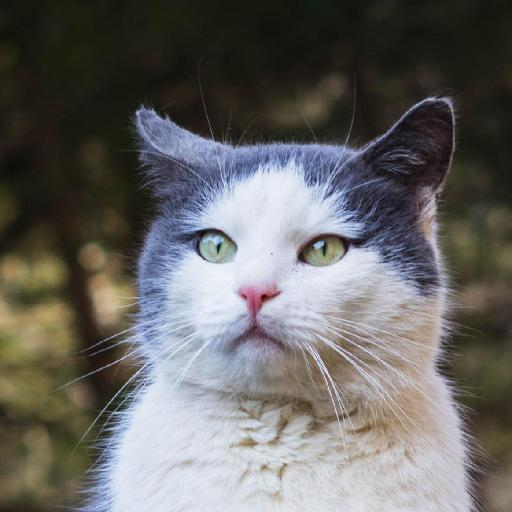

In [9]:
load_img('/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_004834.jpg')

# Train the data

In [10]:
train_dir = '/kaggle/input/animal-faces/afhq/train' #train set
test_dir = '/kaggle/input/animal-faces/afhq/val' #test set

In [11]:
if os.path.isdir(train_dir) and os.path.isdir(test_dir): #cheking if the directories for training & dataset exist
    train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True) #rescaling the image by 1/255 ...

In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
training_set = train_datagen.flow_from_directory(train_dir,target_size=(64, 64),batch_size=32,class_mode='binary') #loading the images from the training directory

Found 14630 images belonging to 3 classes.


In [14]:
test_set = test_datagen.flow_from_directory(test_dir,target_size=(64, 64),batch_size=32,class_mode='binary') #loading the images from the set directory

Found 1500 images belonging to 3 classes.


Print number of samples in the validation set    

In [15]:
print(f'Number of samples in the validation set: {len(test_set)}') #printing the numbers of samples in the validation set

Number of samples in the validation set: 47


# Building the Convolutional Neural Networks (CNNs) model

In [16]:
model = models.Sequential() #creating sequential model
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3))) #adding first convolutional layer ewith 32 layers, kernel size 3x3 & activation function & input shape of 64x64x3
model.add(layers.MaxPooling2D((2, 2))) #pool size of 2x2 to reduce spatial dimensions
model.add(layers.Conv2D(64, (3, 3), activation='relu')) #64 layers & kernels size 3x3
model.add(layers.MaxPooling2D((2, 2))) #pool size of 2x2 to reduce spatial dimensions
model.add(layers.Conv2D(64, (3, 3), activation='relu')) #64 layers & kernels size 3x3

Adding layers on top

In [17]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu')) #actiavtion='relu' -> function returns x if x is greater than 0, and returns 0 otherwise
#dense layer or connected layer is type of layer in neural network where each neuron is connected to every neuron in the preceding layer
model.add(layers.Dense(1))

In [18]:
model.compile(optimizer='adam', #the 'adam' part is opotimizer for the training process
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [19]:
#defining paths for 4 images
img1 = "../input/animal-faces/afhq/train/cat/flickr_cat_000010.jpg"
img2 = "../input/animal-faces/afhq/train/dog/flickr_dog_000010.jpg"
img3 = "../input/animal-faces/afhq/train/cat/flickr_cat_000020.jpg"
img4 = "../input/animal-faces/afhq/train/dog/flickr_dog_000020.jpg"
imgs = [img1, img2, img3, img4] #list of image paths
#function to load & preprocess the images
def _load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224)) #loading images with 224x224 pixels
    img = image.img_to_array(img) #converting the image to an array
    img = np.expand_dims(img, axis=0) #expanding the dimensions of the image
    img = preprocess_input(img) #preprocess the image
    return img

In [20]:
import matplotlib.pyplot as plt #matplotlib library for plotting
def _get_predictions(_model): #functioon to get predictions from a model
    f, ax = plt.subplots(1, 4) #subploat with 1 row and 4 columns
    f.set_size_inches(80, 40) #size of the figure
    for i in range(4):
        ax[i].imshow(Image.open(imgs[i]).resize((100, 100), Image.ANTIALIAS)) #resize the image and display it on the subploat
    plt.show() #show the plot
    f, axes = plt.subplots(1, 4) #create another subplot for the precistions
    f.set_size_inches(80, 20) #set the size of the figure
    labels = ['cat', 'dog', 'other'] #defining labels
    for i,img_path in enumerate(imgs):
        img = _load_image(img_path) #load and preprocess the image
        preds  = decode_predictions(_model.predict(img), top=3)[0] #getting tohe best 3 predictions from the model
        #changing the labels of the predictions
        for j in range(3):
            preds[j] = (preds[j][0], labels[j], preds[j][2])
        b = sns.barplot(y=[c[1] for c in preds], x=[c[2] for c in preds], color="blue", ax=axes[i]) #creating bar plot of the predictions
        b.tick_params(labelsize=55) #setting size of the tick labels
        f.tight_layout() #adjust layout of the figure

553467096/553467096 [==============================] - 22s 0us/step


/tmp/ipykernel_26/3706261287.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  ax[i].imshow(Image.open(imgs[i]).resize((100, 100), Image.ANTIALIAS)) #resize the image and display it on the subploat


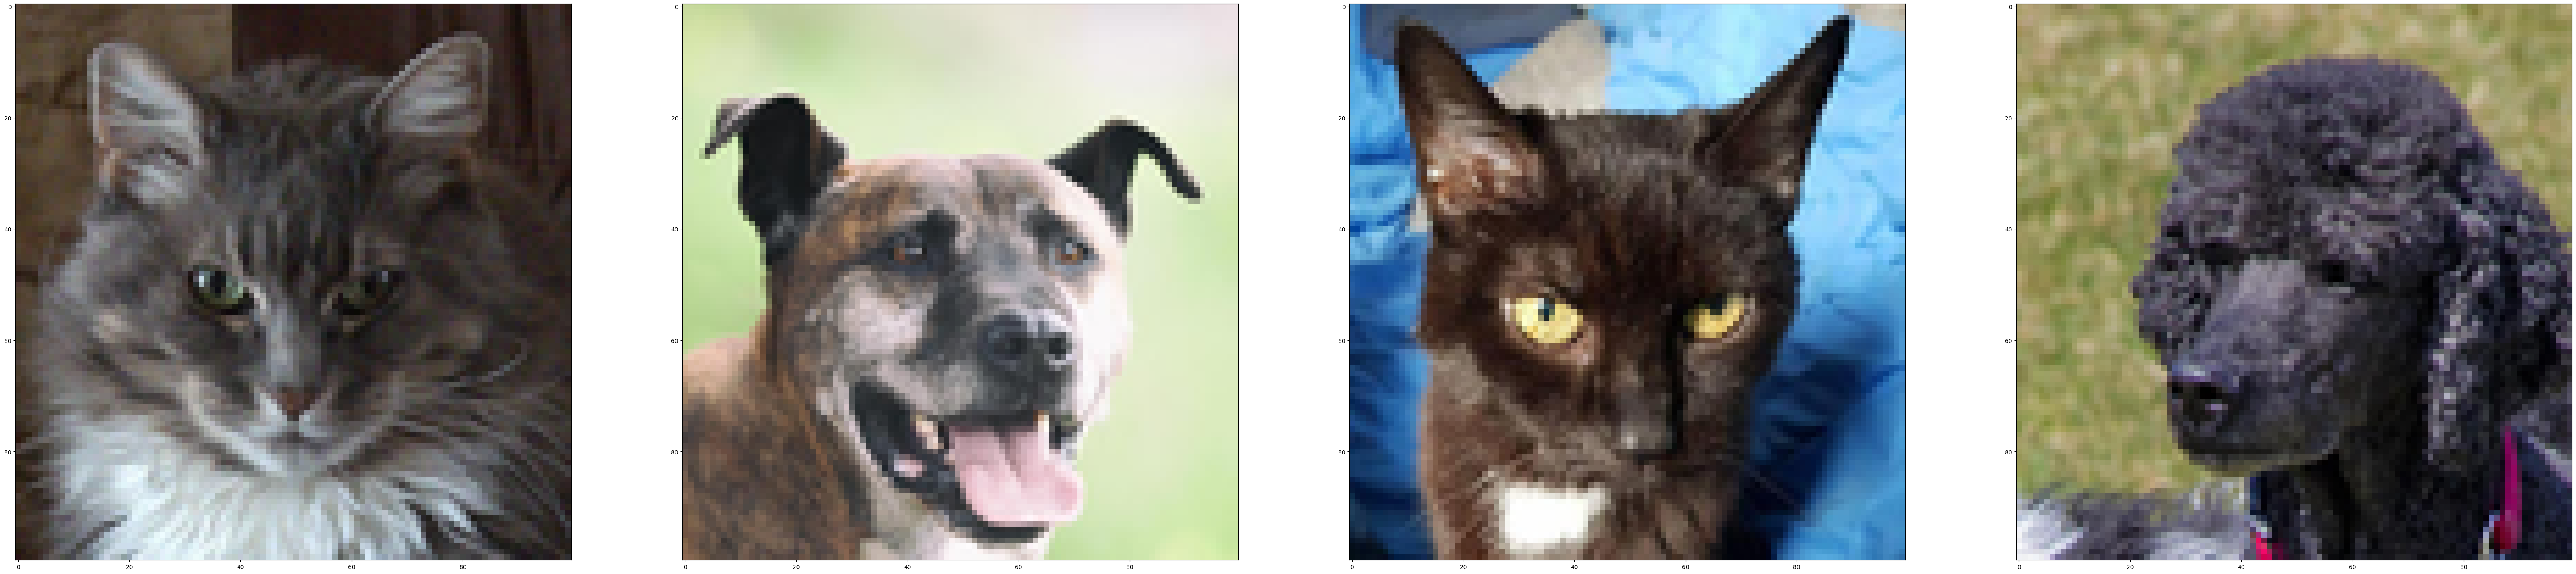

35363/35363 [==============================] - 0s 1us/step


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


1/1 [==============================] - 0s 19ms/step


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


1/1 [==============================] - 0s 18ms/step


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


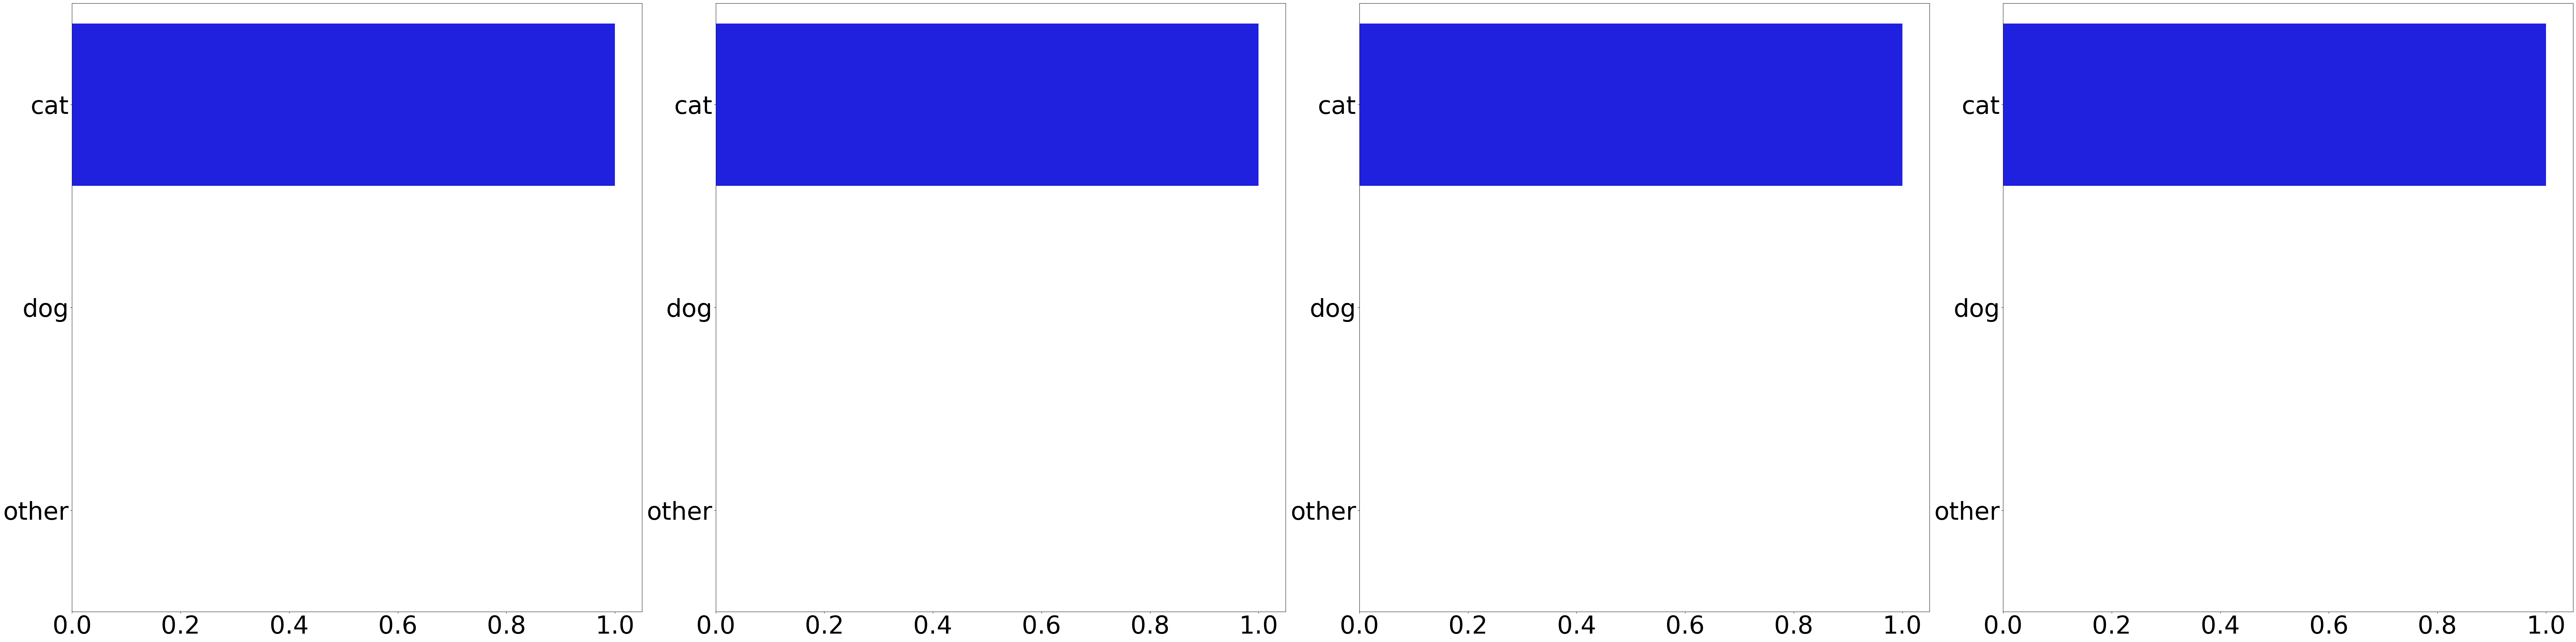

In [21]:
import seaborn as sns #importing seaborn for data visualization
#import the necessary modules from keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
vgg16_model = VGG16(weights='imagenet') #loading VGG16 model with pre-trained weights from the ImageNet dataset
_get_predictions(vgg16_model) #function to get prdictions from the VGG16 model

Training the model

In [22]:
history = model.fit( #function that trains the model for a fixed number of epochs
    training_set, #dataset used for training model
    epochs=10, #number of iterations over the dataset
    validation_data=test_set) #validation the performance of the trained model

Epoch 1/10


I0000 00:00:1711218140.008977      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


458/458 [==============================] - 167s 357ms/step - loss: -2046359.0000 - accuracy: 0.3354 - val_loss: -21691800.0000 - val_accuracy: 0.3440
Epoch 2/10
458/458 [==============================] - 104s 227ms/step - loss: -207540000.0000 - accuracy: 0.3359 - val_loss: -918398976.0000 - val_accuracy: 0.3467
Epoch 3/10
458/458 [==============================] - 91s 199ms/step - loss: -2720710912.0000 - accuracy: 0.3353 - val_loss: -8174206976.0000 - val_accuracy: 0.3433
Epoch 4/10
458/458 [==============================] - 88s 192ms/step - loss: -14562524160.0000 - accuracy: 0.3352 - val_loss: -34778185728.0000 - val_accuracy: 0.3440
Epoch 5/10
458/458 [==============================] - 68s 148ms/step - loss: -46757515264.0000 - accuracy: 0.3365 - val_loss: -96845234176.0000 - val_accuracy: 0.3433
Epoch 6/10
458/458 [==============================] - 74s 161ms/step - loss: -110856519680.0000 - accuracy: 0.3354 - val_loss: -207470673920.0000 - val_accuracy: 0.3447
Epoch 7/10
458/458

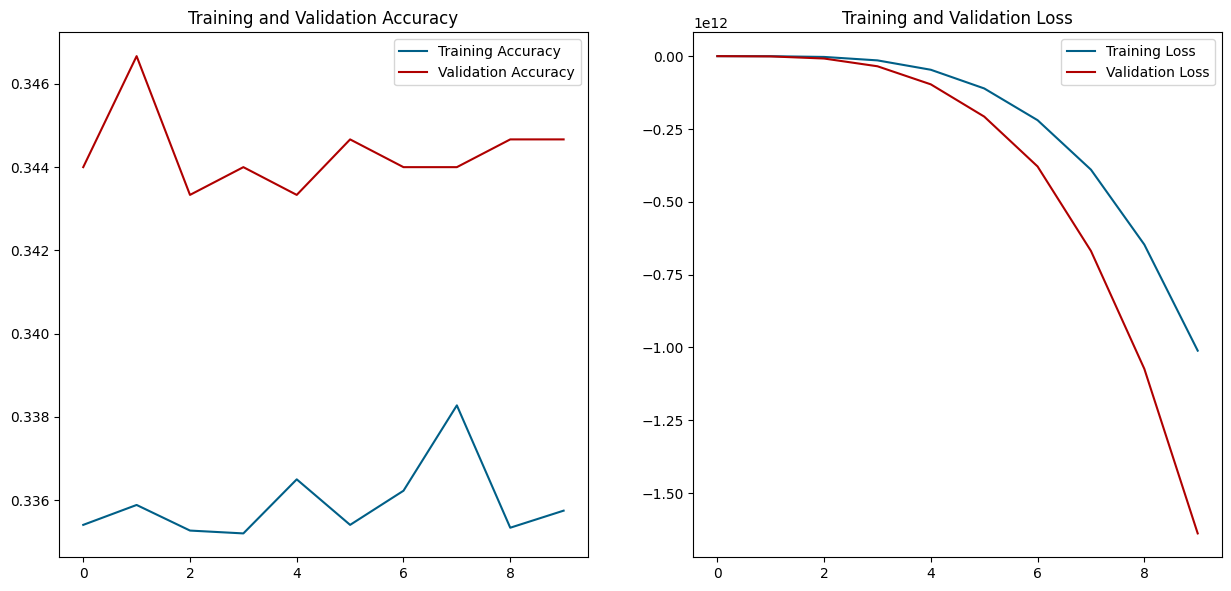

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc)) #represents number of epochs for which the model was trained
plt.figure(figsize=(15, 15)) #creating figure
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='#005f87') #plot for training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='#af0000') #plot for validation accuracy
plt.legend(loc='upper right') #adding legend at the upper right of the plot
plt.title('Training and Validation Accuracy') #add title to the plot
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='#005f87') #plot for training loss
plt.plot(epochs_range, val_loss, label='Validation Loss', color='#af0000') #plot for validation loss
plt.legend(loc='upper right') #adding legend at the upper right of the plot
plt.title('Training and Validation Loss') #add title to the plot
plt.show() #display plots